In [18]:
# Step 0. Import libraries, custom modules and logging
import kagglehub
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
from sklearn.inspection import permutation_importance
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder,
                                   MinMaxScaler,
                                   LabelEncoder,
                                   PowerTransformer
                                  )



In [2]:
# 1. Create dataframe 
path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")
df_raw = pd.read_csv('/home/codespace/.cache/kagglehub/datasets/shubhambathwal/flight-price-prediction/versions/2/Clean_Dataset.csv')



100%|██████████| 4.16M/4.16M [00:00<00:00, 52.5MB/s]

Extracting files...


## **Data Dictionary**
|Name|Description|Units|Type|
|----|-----------|-----|----|
|airline|The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.|none|category|
|flight|Flight stores information regarding the plane's flight code. It is a categorical feature.|none|category|
|Source City|City from which the flight takes off. It is a categorical feature having 6 unique cities.|none|category|
|Departure Time|This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.|none|category|
|Stops| A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.|none|category|
|Arrival Time| This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.|none|category|
|Destination City| City where the flight will land. It is a categorical feature having 6 unique cities.|none|category|
|Class| A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.|none|category|
|Duration| A continuous feature that displays the overall amount of time it takes to travel between cities in hours.|none|float|
|Price| Target variable stores information of the ticket price.|none|int|

In [3]:
# 1.1 Read from source and get basic info
df_raw.info(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [4]:
# 1.2 Get a sample
df_raw.sample(5)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
167093,167093,Indigo,6E-6066,Hyderabad,Morning,zero,Morning,Bangalore,Economy,1.33,18,1776
155266,155266,Air_India,AI-698,Hyderabad,Night,one,Night,Delhi,Economy,22.17,25,4702
298843,298843,Vistara,UK-832,Chennai,Early_Morning,one,Evening,Hyderabad,Business,13.00,22,51457
65901,65901,Air_India,AI-639,Mumbai,Morning,one,Early_Morning,Kolkata,Economy,19.75,26,5070
197453,197453,Indigo,6E-574,Chennai,Evening,zero,Evening,Bangalore,Economy,1.00,46,1443


In [5]:
# Step 2. Prepare the dataset for analysis
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ', '_') # reemplazar espacio por _
        .str.replace(r'\W','',regex=True) # reemplazar caracteres no alfabéticos por nada
        .str.lower() # el resultado lo pasamos a minúsculas
        .str.slice(0,40), axis=1, # slice sirve para cortar el texto a un máximo de 40 caracteres
    )
    .rename(columns={'price':'target'})
    #.astype({'target': np.float16})
    .iloc[:,1:]

)
df_interim["airline"]= df_interim["airline"].astype("category")
df_interim["flight"]= df_interim["flight"].astype("category")
df_interim["source_city"]= df_interim["source_city"].astype("category")
df_interim["departure_time"]= df_interim["departure_time"].astype("category")
df_interim["stops"]= df_interim["stops"].astype("category")
df_interim["arrival_time"]= df_interim["arrival_time"].astype("category")
df_interim["destination_city"]= df_interim["destination_city"].astype("category")
df_interim["class"]= df_interim["class"].astype("category")

df_interim



,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,target
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300148,Vistara,UK-822,Chennai,Morning,one,Evening,Hyderabad,Business,10.08,49,69265
300149,Vistara,UK-826,Chennai,Afternoon,one,Night,Hyderabad,Business,10.42,49,77105
300150,Vistara,UK-832,Chennai,Early_Morning,one,Night,Hyderabad,Business,13.83,49,79099
300151,Vistara,UK-828,Chennai,Early_Morning,one,Evening,Hyderabad,Business,10.00,49,81585


In [6]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            300153 non-null  int64   
 1   airline           300153 non-null  category
 2   flight            300153 non-null  category
 3   source_city       300153 non-null  category
 4   departure_time    300153 non-null  category
 5   stops             300153 non-null  category
 6   arrival_time      300153 non-null  category
 7   destination_city  300153 non-null  category
 8   class             300153 non-null  category
 9   duration          300153 non-null  float64 
 10  days_left         300153 non-null  int64   
dtypes: category(8), float64(1), int64(2)
memory usage: 9.5 MB


In [7]:
df.sample(10)

,target,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left
231297,29094,Air_India,AI-619,Mumbai,Night,one,Morning,Bangalore,Business,14.50,17
9490,4399,GO_FIRST,G8-108,Delhi,Morning,one,Afternoon,Mumbai,Economy,4.92,47
94704,5178,Indigo,6E-806,Bangalore,Evening,one,Late_Night,Mumbai,Economy,7.50,6
184326,4827,GO_FIRST,G8-302,Chennai,Early_Morning,one,Evening,Delhi,Economy,11.58,29
94387,5179,AirAsia,I5-941,Bangalore,Early_Morning,zero,Early_Morning,Mumbai,Economy,1.67,4
141379,6195,Vistara,UK-772,Kolkata,Morning,one,Evening,Bangalore,Economy,7.33,42
259729,44280,Vistara,UK-854,Bangalore,Evening,one,Morning,Chennai,Business,17.42,20
69971,2836,AirAsia,I5-338,Mumbai,Night,one,Morning,Kolkata,Economy,12.83,48
263766,43910,Air_India,AI-526,Kolkata,Evening,one,Evening,Delhi,Business,23.50,46
30967,5772,Vistara,UK-985,Delhi,Evening,one,Afternoon,Hyderabad,Economy,16.42,19


In [8]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240122 entries, 193521 to 143788
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   target            240122 non-null  int64   
 1   airline           240122 non-null  category
 2   flight            240122 non-null  category
 3   source_city       240122 non-null  category
 4   departure_time    240122 non-null  category
 5   stops             240122 non-null  category
 6   arrival_time      240122 non-null  category
 7   destination_city  240122 non-null  category
 8   class             240122 non-null  category
 9   duration          240122 non-null  float64 
 10  days_left         240122 non-null  int64   
dtypes: category(8), float64(1), int64(2)
memory usage: 9.4 MB


In [9]:
display(df_train.describe(include='category').T)
display(df_train.describe().T)

,count,unique,top,freq
airline,240122,6,Vistara,102169
flight,240122,1559,UK-706,2582
source_city,240122,6,Delhi,49094
departure_time,240122,6,Morning,57052
stops,240122,3,one,200783
arrival_time,240122,6,Night,73214
destination_city,240122,6,Mumbai,47253
class,240122,2,Economy,165367


,count,mean,std,min,25%,50%,75%,max
target,240122.0,20882.541475,22689.732214,1105.00,4783.00,7425.00,42521.00,123071.00
duration,240122.0,12.227363,7.189270,0.83,6.83,11.25,16.17,49.83
days_left,240122.0,26.001533,13.558442,1.00,15.00,26.00,38.00,49.00


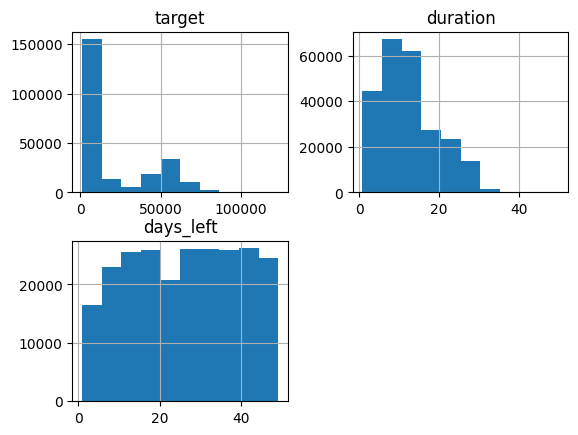

In [10]:
df_train.hist()
plt.show()

<Axes: xlabel='target'>

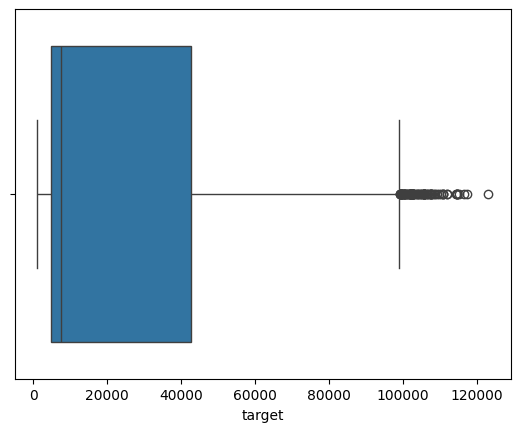

In [11]:

sns.boxplot(data=df_train, x='target')


In [ ]:
label_encoder = LabelEncoder()
for col in df:
    df[col] = label_encoder.fit_transform(df[col])

In [25]:
df.drop("class", axis=1).corr()

,target,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,duration,days_left
target,1.000000,0.239391,0.311021,0.007394,0.056510,-0.190034,0.034988,0.005458,0.245365,-0.229793
airline,0.239391,1.000000,0.637918,-0.028350,0.056885,-0.029838,0.037714,-0.030172,-0.001305,-0.010678
flight,0.311021,0.637918,1.000000,-0.009443,0.071564,-0.118833,0.067175,-0.036248,0.206597,-0.000443
source_city,0.007394,-0.028350,-0.009443,1.000000,-0.004688,0.001819,0.044153,-0.222935,0.008697,-0.003568
departure_time,0.056510,0.056885,0.071564,-0.004688,1.000000,-0.008518,-0.046282,-0.001761,0.084556,-0.001597
stops,-0.190034,-0.029838,-0.118833,0.001819,-0.008518,1.000000,0.010515,-0.012846,-0.476480,-0.007047
arrival_time,0.034988,0.037714,0.067175,0.044153,-0.046282,0.010515,1.000000,-0.037431,0.009155,-0.004191
destination_city,0.005458,-0.030172,-0.036248,-0.222935,-0.001761,-0.012846,-0.037431,1.000000,0.001667,-0.005323
duration,0.245365,-0.001305,0.206597,0.008697,0.084556,-0.476480,0.009155,0.001667,1.000000,-0.039007
days_left,-0.229793,-0.010678,-0.000443,-0.003568,-0.001597,-0.007047,-0.004191,-0.005323,-0.039007,1.000000


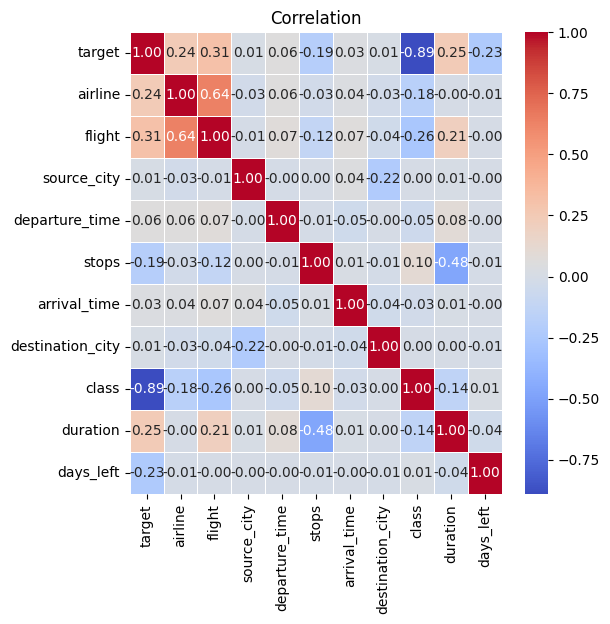

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 6))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation')
plt.show()

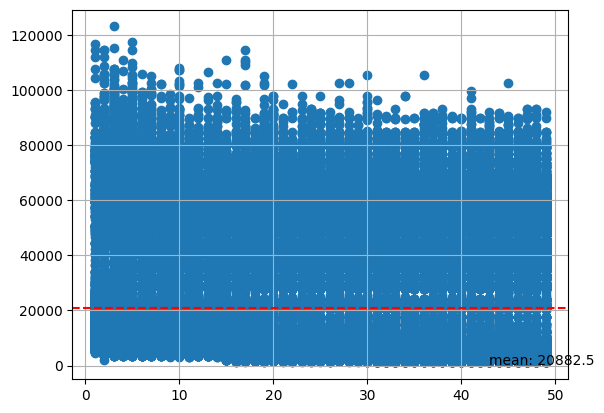

In [14]:
# 3.5 Perform bivariate analysis as a trend
plt.scatter(df_train['days_left'],df_train['target'])
plt.axhline(df_train['target'].mean(),linestyle='--', c='r')
plt.annotate(text=f'mean: {df_train['target'].mean():.1f}', xy=(43,160))
plt.grid(True)
plt.show()

In [15]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [16]:
# 4.2 Modelo simple 
y_mean = np.repeat(df_train["target"].mean(),len(y_test))
print(f'MSE: {mean_squared_error(y_test,y_mean)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_mean))}')

print(f'MAE: {mean_absolute_error(y_test,y_mean)}')
print(f'R2: {r2_score(y_test,y_mean)}')

MSE: 516647660.3662721
RMSE: 22729.884741596736
MAE: 19780.48752245824
R2: -2.452362734439717e-06


In [17]:
num_cols = X_train.select_dtypes('number').columns
cat_cols = X_train.select_dtypes('category').columns

In [19]:
# Pipelines because we have numeric and non numeric values
cat_proc = Pipeline([
    ('imputer', SimpleImputer(strategy= 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # ignore unknow
])
num_proc = Pipeline([
    ('nimputer', SimpleImputer(strategy= 'mean')),
    ('scaler', MinMaxScaler())
])
processor = ColumnTransformer([
    ('cat', cat_proc, cat_cols),
    ('num', num_proc, num_cols)
])

In [21]:
reg_lin = Pipeline([
    ('proc', processor),
    ('lin', LinearRegression())
])

In [22]:
# Modelo de regresión lineal 
reg_lin.fit(X_train,y_train)
y_pred = reg_lin.predict(X_test)
y_pred

/workspaces/Proyecto_final/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([14172.13868971,  2344.10815769,  7749.99759112, ...,
       -3861.87464841,   793.42252992, 11438.65164134])

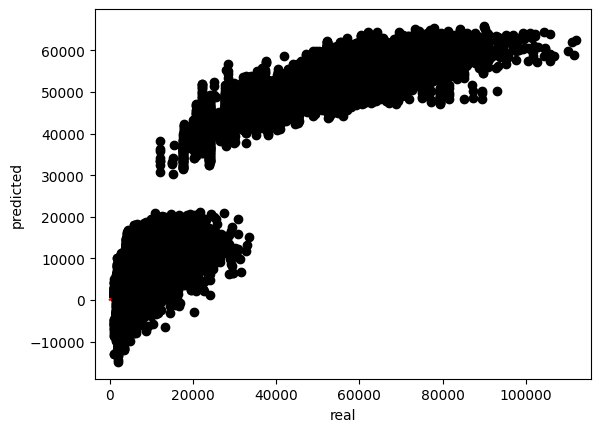

In [24]:
plt.scatter(x= y_test, y= y_pred, c= 'k')
plt.plot([70,230], [70,230], c= 'r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [23]:
print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test,y_pred))}')

print(f'MAE: {mean_absolute_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')

MSE: 38521357.170365594
RMSE: 6206.557594219649
MAE: 4285.427368394316
R2: 0.9254396088595523
